This notebook provides a Python implementation of the Weusten et al. (2011) model for residual risk of HIV transfusion transmission with NAT screening.

**Please note: for some reason not all the equations display correctly on Github, but they do display correctly in recent versions of Jupyter or Jupyter Lab.**

This code implements a mathematical model for deriving "risk day equivalents" (i.e. infectious window period), in the case of nucleic acid screening of blood donations for viruses like HIV, for the purposes of estimating residual risk of transfusion transmission. In this implementation, we assume that the user will have an estimate of incidence in the donor population, which when multiplied by the "risk day equivalents" estimate will yield the risk that any given donation will transmit the virus.

The model is described in:
* Weusten, J., Vermeulen, M., van Drimmelen, H. and Lelie, N. (2011) Refinement of a viral transmission risk model for blood donations in seroconversion window phase screened by nucleic acid testing in different pool sizes and repeat test algorithms. Transfusion, 51: 203-215. doi:[10.1111/j.1537-2995.2010.02804.x](https://doi.org/10.1111/j.1537-2995.2010.02804.x).

Code copyright Eduard Grebe <EGrebe@vitalant.org>, 2019. Released under the GNU General Public Licence Version 3.0.

#### Suggested citation

If you use this code in published research, I suggest citing both the Westen article and this notebook, by means of the DOI on Zenodo:
* Grebe, E. (2019) Residual risk of HIV transfusion transmission with NAT screening. Jupyter Notebook version 1.0. doi:[10.5281/zenodo.3588570](https://doi.org/10.5281/zenodo.3588570).


# Weusten model

We use the model of Weusten et al. (2011), which is an improvement on Weusten et al. (2002).

The model relies on four basic concepts:

1. Probability that a random donor donates during the WP of infection
2. The probability that a donor has mounted a certain viral load in the log-linear ramp-up phase of viraemia (depending on doubling time/growth rate)
3. The probability that a certain viral concentration is not detected (by NAT)
4. The probability that the amount of virus in the released blood component leads to an infection

## Parameters

Key parameters in the model include:

1. 50% infectious dose `N50` (in copies/mL and virions/mL)
2. Doubling time or log-growth rate (in log10 copies(/mL)/day) or as viral doubling time (in days)
3. Assay 95% LoD
4. Assay 50% LoD

*Note that we will ignore the Weusten formula based on total visiting repeat donors, IDIs, etc. and use incidence instead*

We are therefore leaving out parameters relevant to that calculation, nl. $D_{total}$, $D_{conv}$ and $t_{between}$.

Definitions and corresponding variable names:

| Symbol       | Python variable           | Description                                                   |
| ------------ | ------------------------- | ------------------------------------------------------------- |
| $\lambda$    | `doubling_time`           | Doubling time                                                 |
| $\chi$       | `copies_per_virion`       | Number of RNA copies per virion                               |
| $\Phi(x)$    | `scipy.stats.norm.cdf()`  | Cumulative standard normal                                    |
| $C$          | `concentration()` and `C` | Concentration of viral particles in donor blood               |
| $C_0$        | `C0`                      | $C$ at $t=0$, i.e. at start of window period                  |
| $n$          | `n_copies`                | Number of copies (of viral RNA) **Used?**                     |
| $m_{retest}$ | `retests`                 | Number of times a pool initially found reactive is retested   |
| $p_v$        | `infectivity_pv`          | Probability that a single viral particle leads to infection   |
| $r_{days}$   | `risk_days`               | Overall risk in days, i.e. window period risk day equivalents |
| $S_{pool}$   | `pool_size`               | Pool size                                                     |
| $t$          | `t`                       | Time (in the window period)                                   |
| $V_{trans}$  | `volume_transfused`       | Volume of donor blood used in transfusion                     |
| $X_{50}$     | `lod50`                   | Number of copies associated with 50% probability of detection |
| $X_{95}$     | `lod95`                   | Number of copies associated with 95% probability of detection |
| $z$          | `z`                       | Value defined such that $\Phi(z)=0.95$, thus $z=1.6449$       |


## Equations and functions

In [1]:
import math
import numpy as np
import scipy.stats as stats
from scipy.integrate import quad
import statistics
import matplotlib.pyplot as plt

Equation A1:

$$C(t) = C_0 2^{\frac{t}{\lambda}}$$

In [2]:
def concentration(C0, doubling_time, t):
    concentration = C0 * 2 ** (t/doubling_time)
    return concentration

Expected number of virions in blood product is a random variable with Poisson distribution, and is a function of viral load/concentration (in virions/mL) in the donor, and the volume transfused, so that 

Pr(n virions in transfusion product) (A2):

$$P_n=\frac{C \cdot V_{trans}^n exp(-C \cdot V_{trans})}{n!}$$

and

Pr(n virions lead to infection) (A3):

$$P_{infection}(n)=1-(1-p_v)^n$$

so that total probability that infection develops Pr(infectious) (A4) is:

$$P_{infectious} = 1-exp(-C \cdot V_{trans} \cdot p_v)$$

with $C$ defined in equation A1. (A4 is already simplified in Weusten's derivation.) The same equation can be stated simply in terms of $N$, the expected number of virions in a blood product (Eq 1 in Weusten):

$$P_{infectious} = 1-exp(-N \cdot p_v)$$

Note that there is a simple relationship between the 50% infectious dose $ID_{50}$ and $p_v$ can be derived from the previous equation:

$$ID_{50} \cdot p_v = \ln(2)$$

$$p_v = \frac{\ln(2)}{ID_{50}}$$

This is useful because we have published estimates of infectious dose from animal experiments.

In [3]:
def infectivity_per_virion(ID50):
    pv = math.log(2) / ID50
    return pv

def prob_infectious(t, C0, doubling_time, volume_transfused, infectivity_pv):
    C = concentration(C0, doubling_time, t)
    prob = 1 - math.exp(-C * volume_transfused * infectivity_pv)
    return prob

Probability positive for any one test given $n$ copies per sample (A5):

$$P_{+} = \Phi\left(z \frac{\log_{10}(\frac{n}{X_{50}})}{\log_{10}(\frac{X_{95}}{X_{50}})}\right)$$

Probability of non-detection, where there is initial testing in a pool and then singlicate retesting, is simple:

Pr(nondetection) (A6)

$$P_{nondetection}= 1 - P_{+,initial} \cdot (1 - P_{-,retest})$$

So we need formulas for each of those probabilities (given in A7 and A9. Note we ignore a regime where the entire pool is retested, and only consider a regime where each individual donation is retested when the pool was found positive (the regime where entire pool is retested is considered in A8 not shown here). (Also remember the concentration $C$ is in /mL or otherwise normalized, and the LoD values are in the same units and take account of input volume. We therefore do not need to consider input volume at all.) (Are we assuming there can be only one positive donation in the pool? Not if $m_{retest}$ correctly captures the number of chances that *each donation/sample* gets to test negative.)

$$P_{+,initial} = \Phi\left(z \frac{\log_{10}\left(\frac{\chi C_0 2^{t/\lambda}}{S_{pool} X_{50}}\right)}{\log_{10}(\frac{X_{95}}{X_{50}})}\right)$$

$$P_{-,retest} = \left(1 - \Phi\left(z \frac{\log_{10}\left(\frac{\chi C_0 2^{t/\lambda}}{X_{50}}\right)}{\log_{10}(\frac{X_{95}}{X_{50}})}\right)\right)^{m_{retest}}$$

In [4]:
def prob_pos_init(C,
                  doubling_time,
                  pool_size,
                  lod50,
                  lod95,
                  z
                 ):
    if (not isinstance(pool_size, int)) or pool_size < 1:
        raise Exception("pool_size must be an integer of at least 1")
    
    # C is in copies_per_virion, should be "copies_per_virion * C" when C in v/mL
    X = z * (math.log10(((C) / (pool_size * lod50))) / math.log10((lod95/lod50)))
    prob = stats.norm.cdf(X)
    return prob

def prob_neg_retest(C,
                    doubling_time,
                    pool_size,
                    lod50,
                    lod95,
                    retests,
                    z
                   ):
    if (not isinstance(pool_size, int)) or pool_size < 1:
        raise Exception("pool_size must be an integer of at least 1")
        
    if (not isinstance(retests, int)) or retests < 0:
        raise Exception("retests must be a positive integer")
    elif retests == 0:
        return 0
    elif retests >= 1:
        # C is in copies_per_virion, should be "copies_per_virion * C" when C in v/mL
        X = z * (math.log10(((C) / lod50)) / math.log10((lod95/lod50)))
        prob = (1 - stats.norm.cdf(X)) ** retests
        return prob

def prob_nondetection(t,
                      copies_per_virion,
                      C0,
                      doubling_time,
                      pool_size,
                      lod50,
                      lod95,
                      retests,
                      z = 1.6449
                     ):
    Cv = concentration(C0, doubling_time, t)
    Cc = copies_per_virion * Cv
    p_pos_init = prob_pos_init(Cc, doubling_time, pool_size, lod50, lod95, z)
    p_neg_retest = prob_neg_retest(Cc, doubling_time, pool_size, lod50, lod95, retests, z)
    prob = 1 - p_pos_init * (1 - p_neg_retest)
    return prob


To get the total risk-day equivalents, we simply need to get the area under the joint probability of infectiousness and non-detection (A10):

$$r_{days} = \int_{-\infty}^{\infty} P_{infectious} \cdot P_{nondetection} dt$$

*Note that we call it risk-day equivalents, but really the unit of time is arbitrary and would be whatever you express the doubling time in. Hours or years would work too with exactly the same formula.*

In [5]:
def prob_infectious_nondetection(t,
                                 copies_per_virion,
                                 C0,
                                 doubling_time,
                                 volume_transfused, 
                                 infectivity_pv,
                                 pool_size,
                                 lod50,
                                 lod95,
                                 retests,
                                 z = 1.6449
                                ):
    product = (prob_infectious(t, C0, doubling_time, volume_transfused, infectivity_pv) * 
            prob_nondetection(t, copies_per_virion, C0, doubling_time, pool_size,lod50,lod95,retests,z))
    return(product)

def risk_days(copies_per_virion,
              C0,
              doubling_time,
              volume_transfused, 
              infectivity_pv,
              pool_size,
              lod50,
              lod95,
              retests,
              z = 1.6449,
              limits = (-100,500)
             ):
    # Ideally we would integrate from -np.inf to np.inf, but that causes an overflow error, so we choose safe limits instead
    rd = quad(prob_infectious_nondetection, limits[0], limits[1], 
              args=(copies_per_virion,C0,doubling_time,volume_transfused,infectivity_pv,pool_size,lod50,lod95,retests,z))[0]
    return rd

# Example

We will calculate residual risk of HIV transfusion transmission in a demonstrative scenario, where:

* All donations are screened with the Procleix Ultrio Plus multiplexed NAT assay 
    * Initial screening in minipools of 32 samples
    * If a pool is positive, each sample is tested once by the same assay and the unit released if negative
* The transfused product is 
    * packed red blood cells, which contain an average of 20mL of plasma or 
    * fresh frozen plasma with a volume of 200mL
* The HIV incidence in the donor population is 20 cases/100,000 person-years

## Parameter values

We need to set sensible values for all the parameters identified above. Note the following:

* HIV is a double-stranded RNA virus, with two copies of RNA per virion.
* Following Weusten et al., we are setting the $ID_{50}$ based on the median of the log of copy numbers that infected no and all animals respectively. This is a bit of a stretch – we simply have too little information available to derive a sensible $ID_{50}$ and a plausible range around it. We obtain the numbers used here from Ma et al. (2009).
* Weusten at al. mention a "worst case scenario" of $p_v=1$, i.e. a single virion present in the transfused product is guaranteed to cause an infection. This is sensible to consider.
    * We will additionally assume incidence is 10/100,000PY in the worst-case scenario
* Doubling time during the log-linear growth ("ramp-up") phase of infection was estimated at 20.5 hours by Fiebig et al. (2003)
* Assay limit of detection is usually estimated by probit analysis after testing serial dilutions of an analytic standard, standardized in international units (IU)/mL. The conversion factor between IU/mL and copies/mL is 1.72IU/RNA copy in WHO literature.

In [6]:
copies_per_virion = 2

copies_none_infected = 2 # Ma, Stone et al. (2009)
copies_all_infected = 20 # Ma, Stone et al. (2009)
ID50c = math.exp(statistics.median([math.log(copies_none_infected), math.log(copies_all_infected)]))
ID50v = ID50c / copies_per_virion
infectivity_pv = infectivity_per_virion(ID50v)
infectivity_pv_worst = 1

C0 = 0.00025 # arbitrary and doesn't matter - set to approximately 1 virion / 4L of blood
doubling_time = 0.8542 # 20.5/24 Fiebig et al. (2003)
volume_transfused_rbc = 20.0 # An Red Blood Cell unit typically includes 20mL of plasma
volume_transfused_ffp = 200.0 #A fresh frozen plasma unit is typically 200mL 

IUs_per_copy = 1.72 # The WHO uses this conversion factor
lod50 = 4.7 / IUs_per_copy # Procleix Ultrio Plus analytical sensitivity by Probit analysis (Gen-Probe, 2012, p. 40)
lod95 = 21.2 / IUs_per_copy # Procleix Ultrio Plus analytical sensitivity by Probit analysis (Gen-Probe, 2012, p. 40)

pool_size = 32
retests = 1

incidence = 20 / 1e5 # in cases/person-year

## Residual transmission risk from RBC transfusions

* Risk-day equivalents:

In [7]:
iwp_risk_days_rbc = risk_days(copies_per_virion, C0, doubling_time, volume_transfused_rbc, 
                              infectivity_pv, pool_size, lod50, lod95, retests)
print(round(iwp_risk_days_rbc, 2))
iwp_risk_years_rbc = iwp_risk_days_rbc / 365.25

7.19


* Residual risk point estimate (per million transfusions)

In [8]:
RR_rbc = incidence * iwp_risk_years_rbc * 1e6
print(round(RR_rbc, 3))

3.937


## Residual transmission risk from FFP transfusions

* Risk-day equivalents:

In [9]:
iwp_risk_days_ffp = risk_days(copies_per_virion, C0, doubling_time, volume_transfused_ffp, 
                              infectivity_pv, pool_size, lod50, lod95, retests)
print(round(iwp_risk_days_ffp, 2))
iwp_risk_years_ffp = iwp_risk_days_ffp / 365.25

10.03


* Residual risk point estimate (per million transfusions)

In [10]:
RR_ffp = incidence * iwp_risk_years_ffp * 1e6
print(round(RR_ffp, 3))

5.491


## Worst case scenario

In [11]:
incidence_wc = 30 / 1e5

* RR from RBC transfusions (per million)

In [12]:
iwp_risk_days_rbc = risk_days(copies_per_virion, C0, doubling_time, volume_transfused_rbc, 
                              infectivity_pv_worst, pool_size, lod50, lod95, retests)
print(round(iwp_risk_days_rbc, 2))
iwp_risk_years_rbc = iwp_risk_days_rbc / 365.25
RR_rbc = incidence_wc * iwp_risk_years_rbc * 1e6
print(round(RR_rbc, 3))

9.06
7.442


* RR from FFP transfusions (per million)

In [13]:
iwp_risk_days_ffp = risk_days(copies_per_virion, C0, doubling_time, volume_transfused_ffp, 
                              infectivity_pv_worst, pool_size, lod50, lod95, retests)
print(round(iwp_risk_days_ffp, 2))
iwp_risk_years_ffp = iwp_risk_days_ffp / 365.25
RR_ffp = incidence_wc * iwp_risk_years_ffp * 1e6
print(round(RR_ffp, 3))

11.9
9.773


## Residual risk from RBC transfusions with ID-NAT

Let's see the impact of testing each donation individual with NAT (individual donation nucleic acid testing or ID-NAT).

*Note: we also assume that no retesting takes place that could result in an initially reactive sample being released.*

In [14]:
pool_size_idnat = 1
retests_idnat = 0
iwp_risk_days_rbc = risk_days(copies_per_virion, C0, doubling_time, volume_transfused_rbc, 
                              infectivity_pv, pool_size_idnat, lod50, lod95, retests_idnat)
print(round(iwp_risk_days_rbc, 2))
iwp_risk_years_rbc = iwp_risk_days_rbc / 365.25
RR_rbc = incidence * iwp_risk_years_rbc * 1e6
print(round(RR_rbc, 3))

2.95
1.613


## Plot the probability of infection and non-detection and in our example

### RBC transfusion with MP32 screening

#### Probability of infection

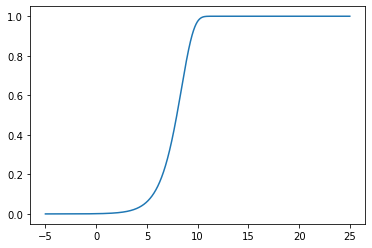

In [15]:
%matplotlib inline
x = np.arange(-5, 25, 0.01)
y = []
for t in x:
    p = prob_infectious(t, C0, doubling_time, volume_transfused_rbc, infectivity_pv)
    y.append(p)
plt.plot(x, y)
plt.show()

### Probability of non-detection

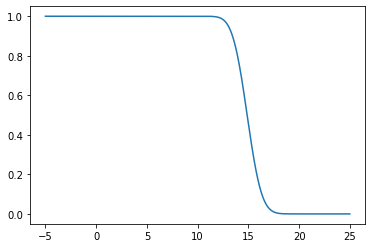

In [16]:
%matplotlib inline
x = np.arange(-5, 25, 0.01)
y = []
for t in x:
    p = prob_nondetection(t, copies_per_virion, C0, doubling_time, pool_size, lod50, lod95, retests)
    y.append(p)
plt.plot(x, y)
plt.show()

### Probability of infection and non-detection

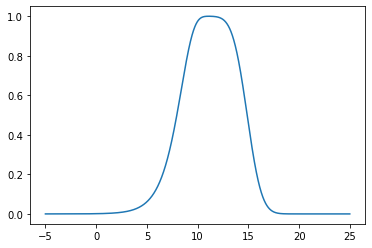

In [17]:
%matplotlib inline
x = np.arange(-5, 25, 0.01)
y = []
for t in x:
    p = prob_infectious_nondetection(t, copies_per_virion,C0,doubling_time,volume_transfused_rbc,
                                     infectivity_pv,pool_size,lod50,lod95,retests)
    y.append(p)
plt.plot(x, y)
plt.show()

### FFP transfusion with MP32 screening

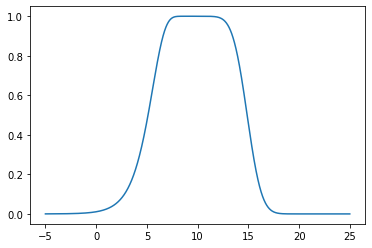

In [20]:
%matplotlib inline
x = np.arange(-5, 25, 0.01)
y = []
for t in x:
    p = prob_infectious_nondetection(t, copies_per_virion,C0,doubling_time,volume_transfused_ffp,
                                     infectivity_pv,pool_size,lod50,lod95,retests)
    y.append(p)
plt.plot(x, y)
plt.show()

### RBC and ID-NAT screening

Note: Here we continue to assume that each donation is retested once, and if not repeat-reactive is released.

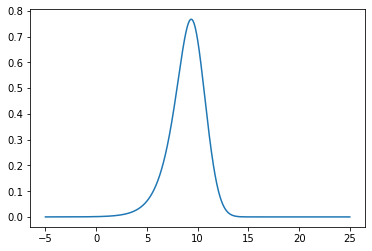

In [21]:
%matplotlib inline
x = np.arange(-5, 25, 0.01)
y = []
for t in x:
    p = prob_infectious_nondetection(t, copies_per_virion,C0,doubling_time,volume_transfused_rbc,
                                     infectivity_pv,pool_size_idnat,lod50,lod95,retests_idnat)
    y.append(p)
plt.plot(x, y)
plt.show()